In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
import os as os

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc, distinct, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Examine the first row of the Measurement table as a dictionary to find the date column for the next step
first_row1 = session.query(Measurement).first()
first_row1.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1afa7d89120>,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'prcp': 0.08}

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

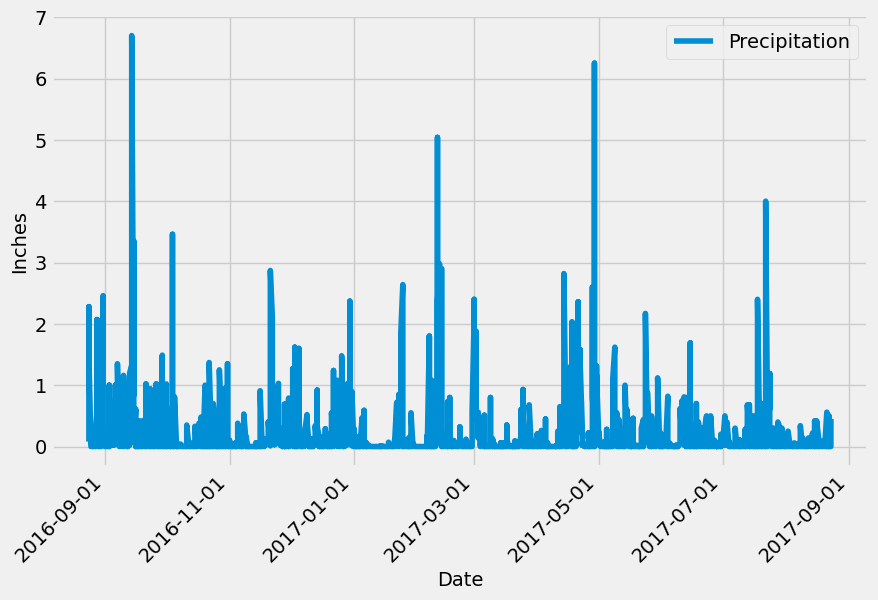

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Calculate the date one year from the last date in data set.
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
select_measurements = [Measurement.date, Measurement.prcp]
precipitation = session.query(*select_measurements).\
        filter(func.strftime(Measurement.date) >= start_date).\
        order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['date', 'prcp'])
precipitation_df.dropna(axis=0, how='any', inplace=True)

# Convert 'date' column to datetime objects
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# Sort the dataframe by date
precipitation_df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = precipitation_df.plot(x='date', y='prcp', rot=45, xlabel='Date', ylabel='Inches', figsize=(9, 6))
plt.tight_layout()

# Format the date on the X-axis as "YYYY-MM-DD"
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set the legend label to "Precipitation"
ax.legend(["Precipitation"])

plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(distinct(Measurement.station))).all()

[(9,)]

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
select_active = [Measurement.station, 
       func.count(Measurement.date)]
active_stations = session.query(*select_active).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]

select_queries = [Measurement.station,
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
station_temp_summary = session.query(*select_queries).\
        filter(Measurement.station == most_active_station_id).\
        group_by(Measurement.station).\
        first()

temperature_summary = tuple(station_temp_summary[1:])  # Wrap temperature values in a tuple
print([temperature_summary])  # Print the list containing the tuple

[(54.0, 85.0, 71.66378066378067)]


Text(0.5, 0, 'Temperature')

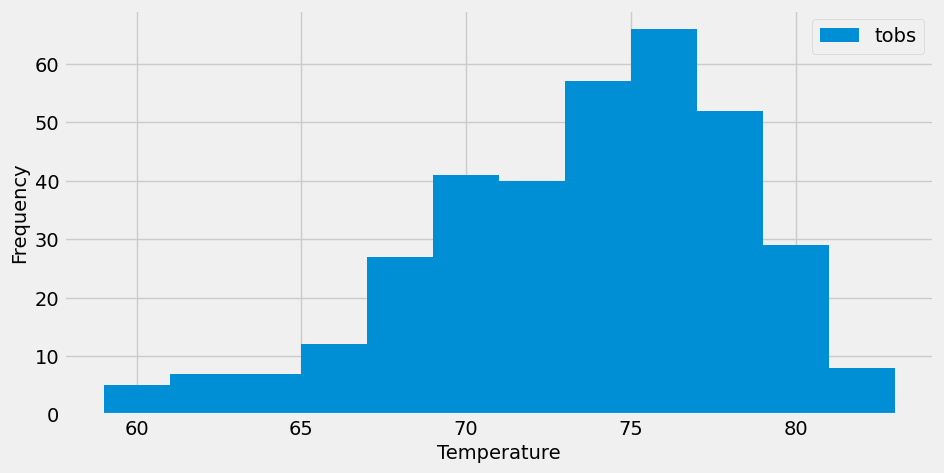

In [17]:
# Using the most active station id
# Calculate the date one year ago from the last date in data set
start_date = latest_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station
data = session.query(Measurement.tobs).\
        filter(Measurement.station == most_active_station_id).\
        filter(Measurement.date >= start_date).all()

station_df = pd.DataFrame(data, columns=['tobs'])

station_df.plot.hist(bins=12, figsize=(10, 5), label="TOBS")
plt.xlabel('Temperature')


# Close Session

In [83]:
# Close Session
session.close()